In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import sparse
from statistics import mode

In [2]:
with open('nodes.txt') as f:
    nodes = f.readlines()

nodes = [i.strip().split('\t') for i in nodes]
nodes_dict = {int(ni[0]):{'Link':ni[1], 'Label':int(ni[2]), 'Name':ni[3]} for ni in nodes}

In [3]:
with open('edges.txt') as f:
    edges = f.readlines()
edges = [i.strip().split('\t') for i in edges]
edges = np.array(edges, dtype=int)

# Remove any edges where the same node is connected to itself
edges = edges[np.array([edges[i, 0] != edges[i,1] for i in range(edges.shape[0])]),:]
# Remove any duplicate edges between the same two nodes since the graph should be undirected
# Sort each edge
for i in range(edges.shape[0]):
    edges[i,:] = np.sort(edges[i,:])
# Remove duplicates
edges = np.unique([tuple(edge) for edge in edges], axis=0)

In [4]:
# Find every unique node that is included in at least one edge
unique_nodes = [int(item) for sublist in edges for item in sublist]
unique_nodes.sort()
unique_nodes = set(unique_nodes)
# Find nodes that don't appear in any edges
remove_nodes = []
for n in nodes_dict.keys():
    if n in unique_nodes:
        continue
    else:
        remove_nodes.append(n)
        
# Remove nodes that don't appear in any edges
for n in remove_nodes:
    del nodes_dict[n]
    
# Add new value for the original index of each point
for k,v in nodes_dict.items():
    nodes_dict[k]['Original_Index'] = k

nodes_reset = dict(enumerate(nodes_dict.values()))

# Create transformed edges array
edges_reset = np.ndarray(edges.shape, dtype=int)

for i in range(edges.shape[0]):
    n0 = [k for k,v in nodes_reset.items() if v['Original_Index'] == edges[i,0]][0]
    n1 = [k for k,v in nodes_reset.items() if v['Original_Index'] == edges[i,1]][0]
    edges_reset[i,0] = n0
    edges_reset[i,1] = n1

In [5]:
# Create adjacency matrix
n = len(nodes_dict.keys())
i = edges_reset[:,0]
j = edges_reset[:,1]
v = np.ones((edges_reset.shape[0],1)).flatten()

A = sparse.coo_matrix((v, (i,j)), shape=(n,n))
A = (A + np.transpose(A))
A = sparse.csc_matrix.todense(A)

# Calculate graph Laplacian
#D = np.diag(np.sum(A, axis=1).A1)
D = np.diag(1/np.sqrt(np.sum(A, axis=1)).A1)
L = D @ A @ D
L = np.array(L)

# Perform eigen decomposition of L
lambd, nu = np.linalg.eig(L)
idx_sorted = np.argsort(lambd)

# Keep the k eigenvectors corresponding to the k largest eigenvalues
k = 5
nu_k = nu[:, idx_sorted[-k:]]
nu_k = nu_k/np.repeat(np.sqrt(np.sum(np.multiply(nu_k,nu_k), axis=1).reshape(-1,1)), k, axis=1)


kmeans = KMeans(n_clusters=k).fit(nu_k.real)
idx = kmeans.labels_

In [6]:
# Calculate mismatch rates within each cluster for all points
total_correct = 0
for cluster in range(k):
    c_points = np.argwhere(idx == cluster)
    c_truelabels = [nodes_reset[p[0]]['Label'] for p in c_points]
    c_majlabel = mode(c_truelabels)
    c_mmrate = round(1 - c_truelabels.count(c_majlabel)/len(c_points),3)
    total_correct += c_truelabels.count(c_majlabel)
    print('Cluster {}: {} points, majority label {}, mismatch rate {}'.format(cluster, len(c_points), c_majlabel, c_mmrate))
print('Total mismatch rate: {}'.format(1-total_correct/n))

Cluster 0: 472 points, majority label 0, mismatch rate 0.021
Cluster 1: 76 points, majority label 1, mismatch rate 0.421
Cluster 2: 588 points, majority label 1, mismatch rate 0.026
Cluster 3: 78 points, majority label 0, mismatch rate 0.026
Cluster 4: 10 points, majority label 1, mismatch rate 0.3
Total mismatch rate: 0.05065359477124187


In [7]:
# Iterate over k values in the range 2-40 to tune for the optimal mismatch rate
mismatch_rates = []
for k in range(2,41):
    lambd, nu = np.linalg.eig(L)
    idx_sorted = np.argsort(lambd)
    nu_k = nu[:, idx_sorted[-k:]]
    nu_k = nu_k/np.repeat(np.sqrt(np.sum(np.multiply(nu_k,nu_k), axis=1).reshape(-1,1)), k, axis=1)
    kmeans = KMeans(n_clusters=k).fit(nu_k.real)
    idx = kmeans.labels_
    
    total_correct = 0
    for cluster in range(k):
        c_points = np.argwhere(idx == cluster)
        c_truelabels = [nodes_reset[p[0]]['Label'] for p in c_points]
        c_majlabel = mode(c_truelabels)
        c_mmrate = 1 - c_truelabels.count(c_majlabel)/len(c_points)
        total_correct += c_truelabels.count(c_majlabel)
        #print('Mismatch rate for cluster {}: {}%'.format(cluster, c_mmrate*100))
    print('Total mismatch rate for k = {}: {}'.format(k, 1-total_correct/n))
    mismatch_rates.append(1-total_correct/n)

Total mismatch rate for k = 2: 0.4787581699346405
Total mismatch rate for k = 3: 0.4787581699346405
Total mismatch rate for k = 4: 0.05392156862745101
Total mismatch rate for k = 5: 0.04738562091503273
Total mismatch rate for k = 6: 0.05147058823529416
Total mismatch rate for k = 7: 0.05228758169934644
Total mismatch rate for k = 8: 0.04738562091503273
Total mismatch rate for k = 9: 0.05718954248366015
Total mismatch rate for k = 10: 0.06127450980392157
Total mismatch rate for k = 11: 0.06045751633986929
Total mismatch rate for k = 12: 0.06127450980392157
Total mismatch rate for k = 13: 0.05555555555555558
Total mismatch rate for k = 14: 0.054738562091503296
Total mismatch rate for k = 15: 0.05228758169934644
Total mismatch rate for k = 16: 0.05228758169934644
Total mismatch rate for k = 17: 0.05555555555555558
Total mismatch rate for k = 18: 0.06290849673202614
Total mismatch rate for k = 19: 0.06127450980392157
Total mismatch rate for k = 20: 0.059640522875817004
Total mismatch rate 

Text(0.5, 1.0, 'Mismatch Rates for k = 2-40')

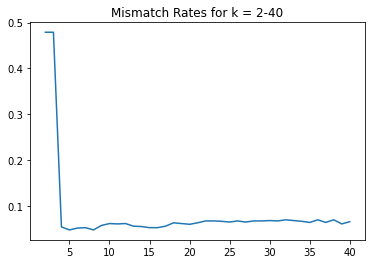

In [8]:
# Plot mismatch rates across range of k values
plt.plot(range(2,41), mismatch_rates)
plt.title('Mismatch Rates for k = 2-40')

Text(0.5, 1.05, 'Adjacency Matrix')

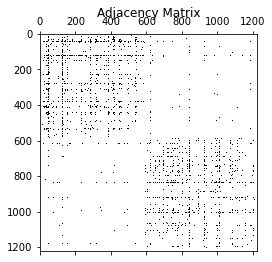

In [10]:
# Plot adjacency matrix
plt.spy(A)
plt.title('Adjacency Matrix')